### Intro:
We have data about all users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

### Your project is to:

- Predict conversion rate

- Come up with recommendations for the product team and the marketing team to improve conversion rate

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)
  
#read from google drive
data=pd.read_csv("https://drive.google.com/uc?export=download&id=1KvxyyF3QCtvIx0J7_8iWDEtFQpLgd0Yq")
  
print(data.head())

  country  age  new_user source  total_pages_visited  converted
0      UK   25         1    Ads                    1          0
1      US   23         1    Seo                    5          0
2      US   28         1    Seo                    4          0
3   China   39         1    Seo                    5          0
4      US   30         1    Seo                    6          0


In [9]:
data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [ ]:
data.describe()

In [ ]:
data.info()

### EDA

Analysis on:
- conversion by country
- conversion by age
- conversion by new/old user
- conversion by source
- conversion by page visited

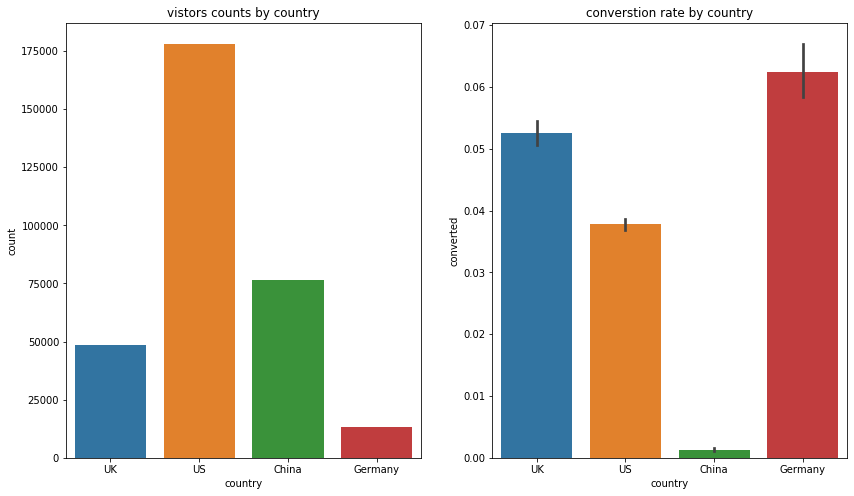

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#conversion by country
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(14, 8))
sns.countplot(x='country', data = data, ax = ax[0])
ax[0].set_title('vistors counts by country')

sns.barplot(x='country', y='converted', data = data, ax = ax[1])
ax[1].set_title('converstion rate by country')

plt.show()

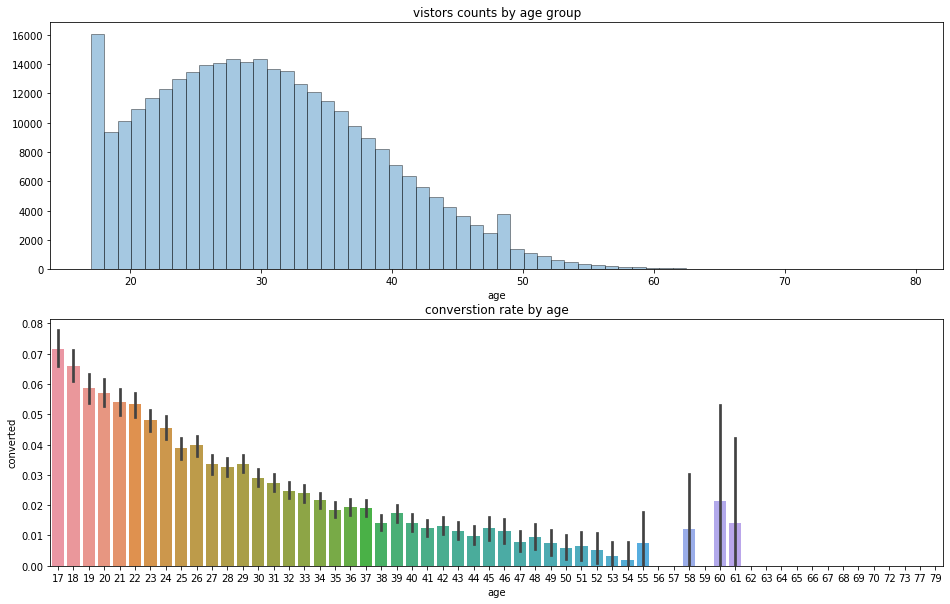

In [7]:
#conversion by age
hist_kws ={'histtype': 'bar', 'edgecolor':'black'}

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16, 10))
sns.distplot(data[data['age'] <80]['age'], hist_kws = hist_kws, kde= False, bins = 60, ax = ax[0])
ax[0].set_title('vistors counts by age group')

sns.barplot(x='age', y='converted', data = data[data['age'] <80], ax = ax[1])
ax[1].set_title('converstion rate by age')

plt.show()

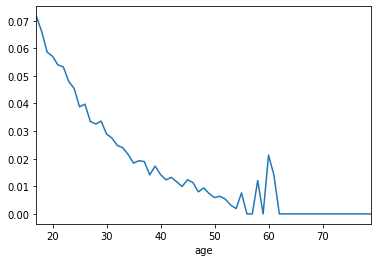

In [8]:
data[data['age'] < 80].groupby('age')['converted'].mean().plot()
plt.show()

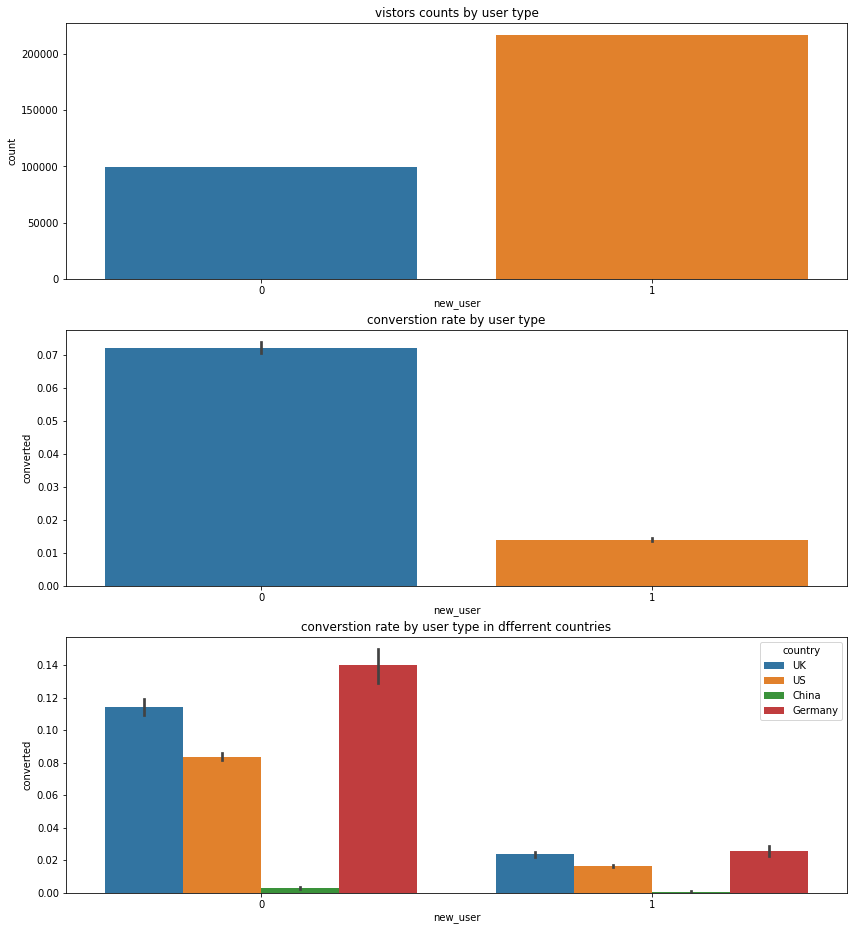

In [9]:
#conversion by user type
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(14, 16))
sns.countplot(x='new_user', data = data, ax = ax[0])
ax[0].set_title('vistors counts by user type')

sns.barplot(x='new_user', y='converted', data = data, ax = ax[1])
ax[1].set_title('converstion rate by user type')

sns.barplot(x='new_user', y='converted', hue = 'country', data = data, ax = ax[2])
ax[2].set_title('converstion rate by user type in dfferrent countries')

plt.show()

Text(0.5, 1.0, 'vistors counts by user type')

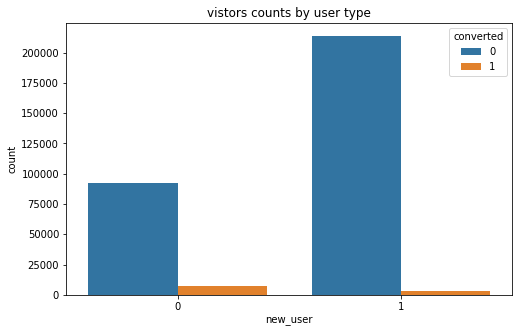

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x='new_user', data = data, hue = 'converted', ax =ax)
ax.set_title('vistors counts by user type')

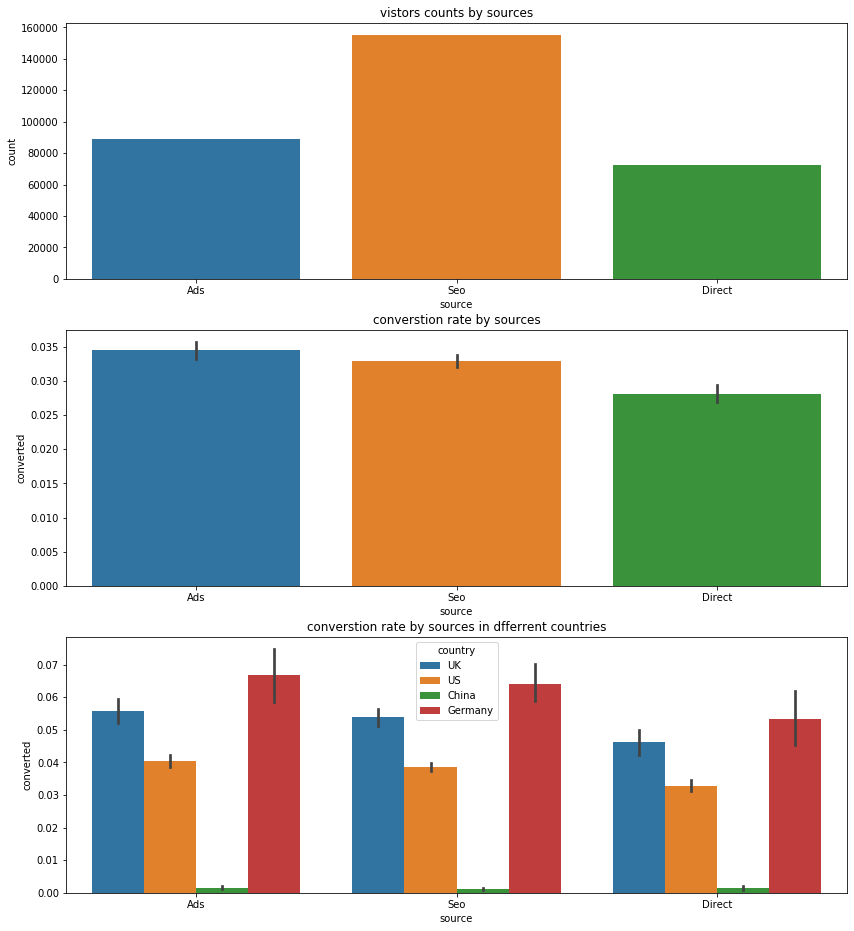

In [11]:
#conversion by user type
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(14, 16))
sns.countplot(x='source', data = data, ax = ax[0])
ax[0].set_title('vistors counts by sources')

sns.barplot(x='source', y='converted', data = data, ax = ax[1])
ax[1].set_title('converstion rate by sources')

sns.barplot(x='source', y='converted', hue = 'country', data = data, ax = ax[2])
ax[2].set_title('converstion rate by sources in dfferrent countries')

plt.show()

Text(0.5, 1.0, 'vistors counts by source')

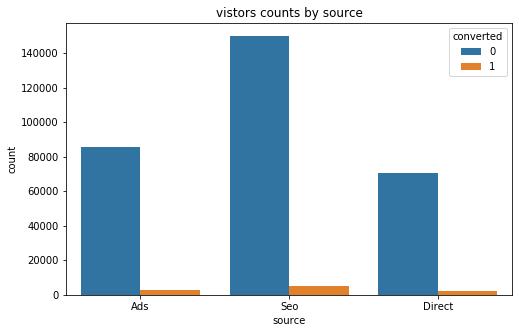

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(x='source', data = data, hue = 'converted', ax =ax)
ax.set_title('vistors counts by source')

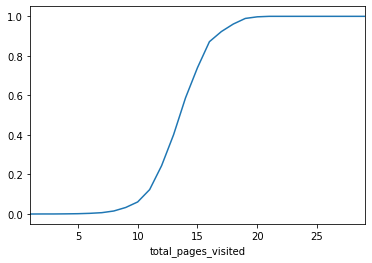

In [13]:
data[data['age'] < 80].groupby('total_pages_visited')['converted'].mean().plot()

### Modeling
- RF classifier to determine important features

In [14]:
data = data[data['age'] < 80]

max(data['age'])

79

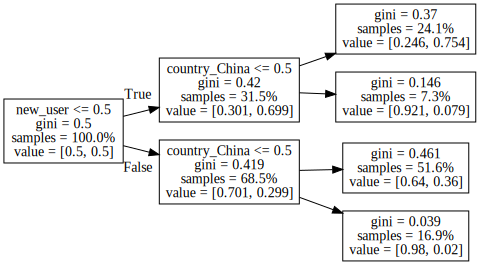

In [18]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
#make date as string, so few dates that makes sense to have them as few dummy values  
df_mdl = data.drop(columns= ['total_pages_visited'])
  
#make dummy vars. Don't drop one level here, keep them all. You don't want to risk dropping the one level that actually creates problems with the randomization
data_dummy = pd.get_dummies(df_mdl)

  
tree=DecisionTreeClassifier(max_depth = 2,
    #change weights. Our data set is now perfectly balanced. It makes easier to understand the tree output
    class_weight="balanced",
    #only split if if it's worthwhile. The default value of 0 means always split no matter what if you can increase overall performance, which creates tons of noisy and irrelevant splits
    min_impurity_decrease = 0.001
    )

train_cols = data_dummy.drop(columns =['converted'])
tree.fit(train_cols, data_dummy['converted'])
  
export_graphviz(tree, out_file="tree_test.dot", feature_names=train_cols.columns, proportion=True, rotate=True)
with open("tree_test.dot") as f:
    dot_graph = f.read()
  
s = Source.from_file("tree_test.dot")
s

In [21]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(4684)

train, test = train_test_split(data_dummy, test_size = 0.34)

rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rf.fit(train.drop('converted', axis = 1), train['converted'])

print('oob score: ', rf.oob_score_)
print(pd.DataFrame(confusion_matrix(train['converted'], rf.oob_decision_function_[:,1].round(), labels=[0, 1])))

oob score:  0.8890129425801784
        0      1
0  182468  19497
1    3665   3061


In [22]:
print(rf.score(test.drop('converted', axis=1), test['converted']))
print(pd.DataFrame(confusion_matrix(test['converted'], rf.predict(test.drop('converted', axis = 1)), labels = [0,1])))

0.8888651182691681
       0      1
0  94002  10033
1   1915   1559


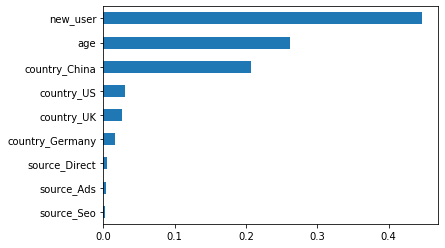

In [23]:
feat_importances = pd.Series(rf.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

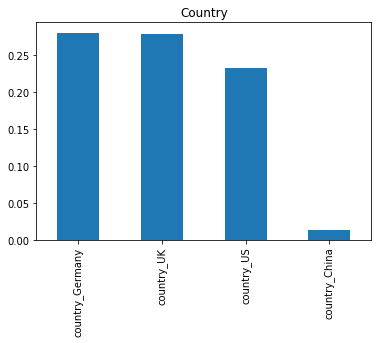

In [30]:
# pip install -q pdpbox

from pdpbox import pdp, info_plots
  
#country
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted'], axis=1),      
                          model_features=list(train.drop(['converted'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US', 'country_China'], 
                          num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

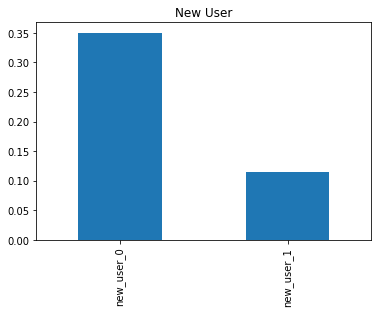

In [32]:
#new user
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted'], axis=1),      
                          model_features=list(train.drop(['converted'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

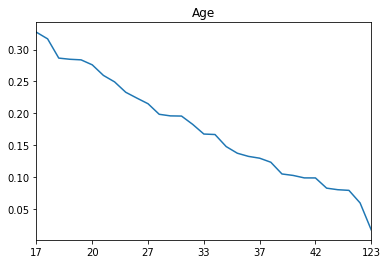

In [34]:
#age
pdp_iso = pdp.pdp_isolate( model=rf, 
                          dataset=train.drop(['converted'], axis=1),      
                          model_features=list(train.drop(['converted'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)

pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(title='Age')
plt.show()

In [1]:
# pip install -q h2o

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch


# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,16 mins 31 secs
H2O cluster timezone:,America/Toronto
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_user_usf69f
H2O cluster total nodes:,1
H2O cluster free memory:,702 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [36]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.569857685009328,,,4.872966476913375,
maxs,,123.0,,,29.0,
sigma,,8.271801801807767,,,3.3411037579482046,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [37]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)


drf Model Build progress: |███████████████████████████████████████████████| 100%


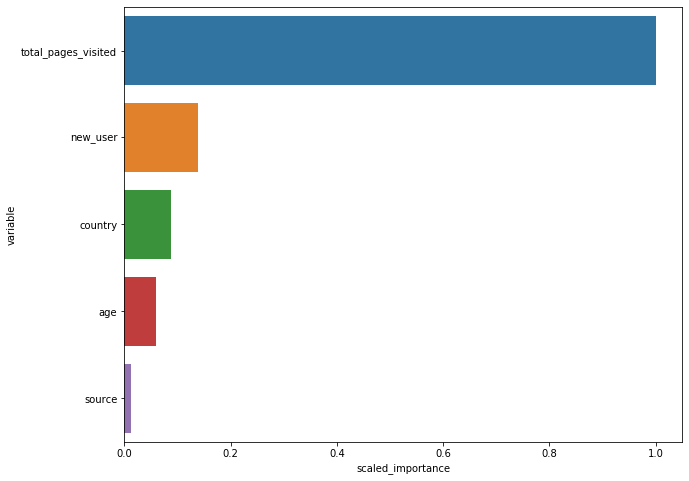

In [39]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [41]:
from sklearn.metrics import auc, roc_curve, classification_report

# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [42]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.83      0.62      0.71      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.81      0.85     79050
weighted avg       0.98      0.98      0.98     79050



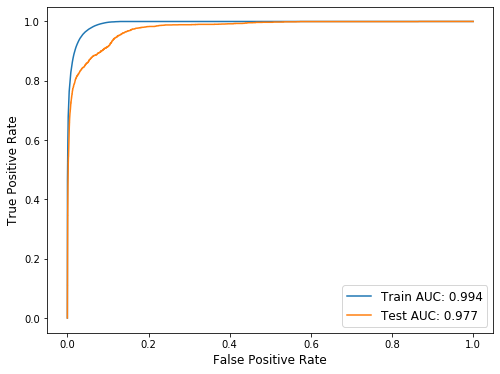

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()